In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

In [2]:
# training data
in_sample = pd.read_json("../input/whatscooking/train.json")
display(in_sample.head())
display(in_sample.describe())

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


,id
count,39774.000000
mean,24849.536959
std,14360.035505
min,0.000000
25%,12398.250000
50%,24887.000000
75%,37328.500000
max,49717.000000


,id,ingredients
cuisine,,
italian,7838,7838
mexican,6438,6438
southern_us,4320,4320
indian,3003,3003
chinese,2673,2673


,id,ingredients
cuisine,,
filipino,755,755
irish,667,667
jamaican,526,526
russian,489,489
brazilian,467,467


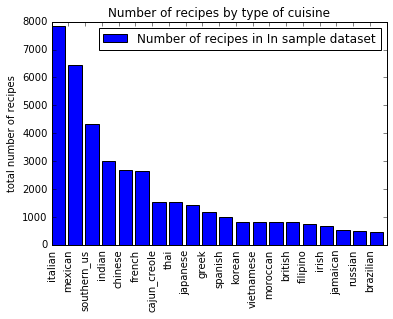

In [3]:
# Analysis on the relative counts of the various y labels
cuisines = in_sample.groupby("cuisine").count().sort_values(by="id", ascending=False)
display(cuisines.head())
display(cuisines.tail())
i = range(cuisines.count().ingredients)
plt.bar(i, cuisines.ingredients, label='Number of recipes in {} dataset'.format("In sample"))
plt.ylabel('total number of recipes')
plt.title('Number of recipes by type of cuisine')
plt.xticks(i, cuisines.index.values, rotation='vertical')
plt.legend(loc='upper right')
plt.show()

In [4]:
# out of sample data
out_of_sample = pd.read_json("../input/whatscooking/test.json")
display(out_of_sample.head())
display(out_of_sample.describe())

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


,id
count,9944.000000
mean,24894.350362
std,14322.958061
min,5.000000
25%,12541.000000
50%,24731.500000
75%,37113.250000
max,49715.000000


In [5]:
import re

def transformations(ingredient_list, return_as_list=False, separator=";;;"):
    ingredients = (separator if return_as_list else " ").join(ingredient_list)
    ingredients = re.sub(r' & ', ' and ', ingredients)
    ingredients = re.sub(r'(\(.*\))', '', ingredients)
    ingredients = re.sub(r'\d+ (onz|ounc|oz|pound|lb|kg|g|cup|tsp|tbsp|ml)\S+ ', '', ingredients)
    ingredients = re.sub(r'\'', '', ingredients)
    ingredients = re.sub(r'\-', '', ingredients)
    ingredients = re.sub(r'/S+', ' ', ingredients)
    ingredients = ingredients.lower()
    return ingredients.split(separator) if return_as_list else ingredients

def analyze_pantry(df, return_as_list=False):
    if not return_as_list:
        display(df.head())
        return
    import itertools
    grouped_ingredients = itertools.groupby(sorted(list(itertools.chain.from_iterable(df.ingredients))))
    ingredient_counts = {key:len(list(group)) for key, group in grouped_ingredients}
    pantry = pd.DataFrame.from_dict(ingredient_counts, orient='index')
    pantry.columns = ['num_recipes']
    pantry = pantry.sort_values(by='num_recipes', ascending=False)
    display(pantry.count())
    display(pantry.head())
    
    # Display odd ingredients
    regexp = re.compile(r'^[0-9a-zA-Z\s\-\,]+$')
    matches = [k for k, v in pantry.num_recipes.iteritems() if not regexp.search(k)]
    print len(matches)
    display(matches)

from functools import partial
transform_as_list = partial(transformations, return_as_list=True)

return_as_list = False
in_sample.ingredients = in_sample.ingredients.map(transform_as_list if return_as_list else transformations)
out_of_sample.ingredients = out_of_sample.ingredients.map(transform_as_list if return_as_list else transformations)

analyze_pantry(in_sample, return_as_list)
analyze_pantry(out_of_sample, return_as_list)

,cuisine,id,ingredients
0,greek,10259,romaine lettuce black olives grape tomatoes ga...
1,southern_us,25693,plain flour ground pepper salt tomatoes ground...
2,filipino,20130,eggs pepper salt mayonaise cooking oil green c...
3,indian,22213,water vegetable oil wheat salt
4,indian,13162,black pepper shallots cornflour cayenne pepper...


,id,ingredients
0,18009,baking powder eggs allpurpose flour raisins mi...
1,28583,sugar egg yolks corn starch cream of tartar ba...
2,41580,sausage links fennel bulb fronds olive oil cub...
3,29752,meat cuts file powder smoked sausage okra shri...
4,35687,ground black pepper salt sausage casings leeks...


In [6]:
from sklearn.cross_validation import train_test_split
# 90 - 10 split (Cross validated grid search set)
train, test = train_test_split(in_sample, test_size = 0.1, stratify=in_sample.cuisine)
train.head()

,cuisine,id,ingredients
8875,italian,28795,olive oil toasted baguette garlic cloves chopp...
4783,italian,19122,tomato sauce paprika minced garlic tomato past...
12394,italian,2736,eggplant large garlic cloves garlic cloves fre...
17930,thai,16574,"peanut butter boneless, skinless chicken breas..."
15396,chinese,4204,soy sauce sweet soy sauce salt eggs lap cheong...


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

In [8]:
param_grid = {
    'vectorizer__max_df':[0.6],
    'vectorizer__min_df':[0.0],
    'vectorizer__max_features':[None],
    'vectorizer__ngram_range' : [(1, 2)],
    'vectorizer__binary' : [True],
    'vectorizer__strip_accents' : ['unicode'],
    'classifier__C': [19.38],
    'classifier__gamma' : [0.291],
    'classifier__class_weight': ['balanced'],
    'classifier__decision_function_shape' : ['ovr']
}

pipeline = Pipeline([('vectorizer', TfidfVectorizer()),
                     ('classifier', SVC())])

cv = StratifiedKFold(train.cuisine, n_folds=3, shuffle=True)

grid = GridSearchCV(pipeline, cv=cv, param_grid=param_grid, n_jobs=2, verbose=1)
grid.fit(train.ingredients, train.cuisine)
grid.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 11.6min finished


{'classifier__C': 19.38,
 'classifier__class_weight': 'balanced',
 'classifier__decision_function_shape': 'ovr',
 'classifier__gamma': 0.291,
 'vectorizer__binary': True,
 'vectorizer__max_df': 0.6,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 0.0,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__strip_accents': 'unicode'}

In [11]:
grid.score(train.ingredients, train.cuisine)

0.99913393306140696

In [9]:
grid.score(test.ingredients, test.cuisine)

0.79120603015075375

In [10]:
predictions = grid.predict(out_of_sample.ingredients)
out_of_sample['cuisine'] = predictions
submission = out_of_sample[['id', 'cuisine']]
import time
submission.to_csv('../output/whatscooking/whatscooking-{}.csv'.format(time.strftime("%Y%m%d--%H%M%S")), index=False)

My final score on the out of sample test set was .79254 which was very close to the test score on the held out dataset, even though E_in_sample, expectedly, was higher.